 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** : In progress
 
**Purpose**: We propose here an assimilation problem coupled with Solver DL (deep learning), the goal is to infer the mass **m** and the moment of inertia **$I_\alpha$** of a PAPA from observations made on the displacements.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (13 Juin 2022)

-----------------------------------

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
from tabulate import tabulate

# ------ Importation Local
# utils for Post-Trait ( plot, ..)
sys.path.append("../")
from Post_Trait import POSTRAIT
Path_src     = "../../"
#--- DATA : output of DA code

#--- Config 
PATH_CONF = Path_src+"Inference_Problem/PAPA/" 
sys.path.append(PATH_CONF)

PST_dic = {}

# ---- cas  : EnVar(2)
# Load all results of DA : 
Path_res       = "PAPA/Mass_Ialpha_RcML/"
PATH_DATA      = Path_src+"DATA/DA_4DEnVar_V2/"+Path_res
label1         = "EnVar(2)"
label          = label1
color          = "grey"
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)

# ---- cas  : DL-EnVar(2)
# Load all results of DA : 
Path_res       = "PAPA_FNN/Mass_Ialpha_RcML/"
PATH_DATA      = Path_src+"DATA/DA_4DEnVar_V2/"+Path_res
label2         = "DL-EnVar(2)"
label          = label2
color          = "k"
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)



In [3]:
#PST[label].show_cfg()

### Control Vectors  

In [4]:
all_gamma = [PST_dic[label].CFG.Param_Ref, PST_dic[label].CFG.Param_Est]
index   = ["Reference","Initialisation"]

for key, PST in PST_dic.items() :
    all_gamma.append(PST.Param_Opti)
    index.append("Optimized {"+PST.label+"}")
    
df =pd.DataFrame(all_gamma, index = index,columns=PST_dic[label].CFG.Param_Name)    

print(tabulate(df.T, tablefmt='grid',headers='keys'))
print("")    

+---------+-------------+------------------+------------------------+---------------------------+
|         |   Reference |   Initialisation |   Optimized {EnVar(2)} |   Optimized {DL-EnVar(2)} |
+=========+=============+==================+========================+===========================+
| mass    |       87.07 |             75   |                  87.07 |                  86.9896  |
+---------+-------------+------------------+------------------------+---------------------------+
| I_alpha |        3.73 |              1.8 |                   3.73 |                   3.73042 |
+---------+-------------+------------------+------------------------+---------------------------+



### Function Cost  and HF ratio


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$



\begin{equation}
    J = \underbrace{\frac{1}{2} \Vert \Gama-\Gamae \Vert ^2_{\B^{-1}} }_{J_b}+\underbrace{\frac{1}{2} \sum_{k=0}^{N} \Vert \boldsymbol{y}_k -\boldsymbol{h}(\boldsymbol{x}_k) \Vert^2_{\C^{-1}}}_{J_{obs}}
    \label{eq_J}
\end{equation}



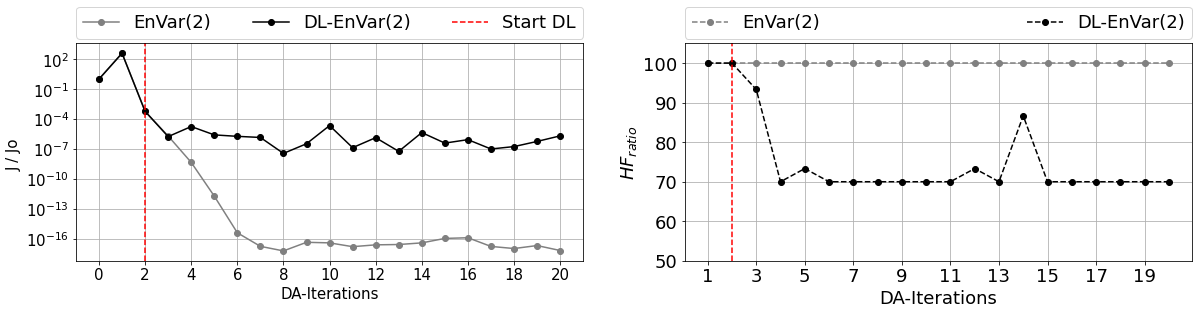

In [5]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
for key, PST in PST_dic.items() :
    PST.plot_Jcost(linestyle='-o')
    if PST.CFG.Use_DL:
        plt.axvline(x=PST.i_start_ML,label="Start DL",c="r",linestyle='--')
    
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)

plt.subplot(1,2,2)
for key, PST in PST_dic.items() :
    PST.plot_HF_ratio(linestyle='--o')
    if PST.CFG.Use_DL:
        plt.axvline(x=PST.i_start_ML,c="r",linestyle='--')
    
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
plt.ylim(50,105)
plt.show()

##  Relative Error  

$$ e_r = \frac{\gamma_{opti} - \gamma_{ref} } {\gamma_{ref}} \times 100$$

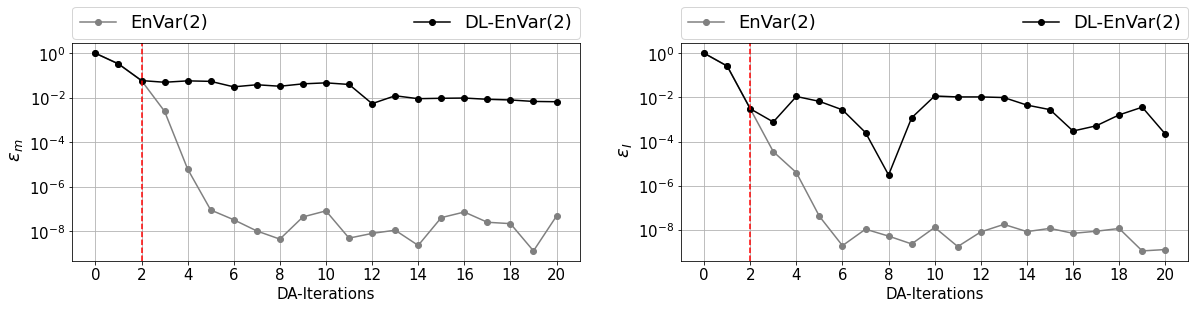

In [6]:
n_col = len(PST.CFG.Param_Name)
plt.figure(figsize=(20,4))

k=1
y_label = [Name[0] for Name in PST.CFG.Param_Name]

for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    for key, PST in PST_dic.items() :
        N_iter  = [j for j in range(len(PST.Param_error))]
        plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c=PST.color,label = PST.label)
        
    new_list = range(math.floor(min(N_iter)), math.ceil(max(N_iter))+1,2)
    plt.xticks(new_list, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('DA-Iterations',fontsize=15)
    plt.ylabel(fr" $\epsilon_{y_label[i]}$",fontsize=18)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)    
    plt.grid()
    plt.axvline(x=PST.i_start_ML,label="Start DL coupled",c="r",linestyle='--')
    
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1


## Reconstruction of Observables 

In [7]:
# plt.figure(figsize=(20,100))
# PST_dic[label1].plot_obs_ref_est_opt()

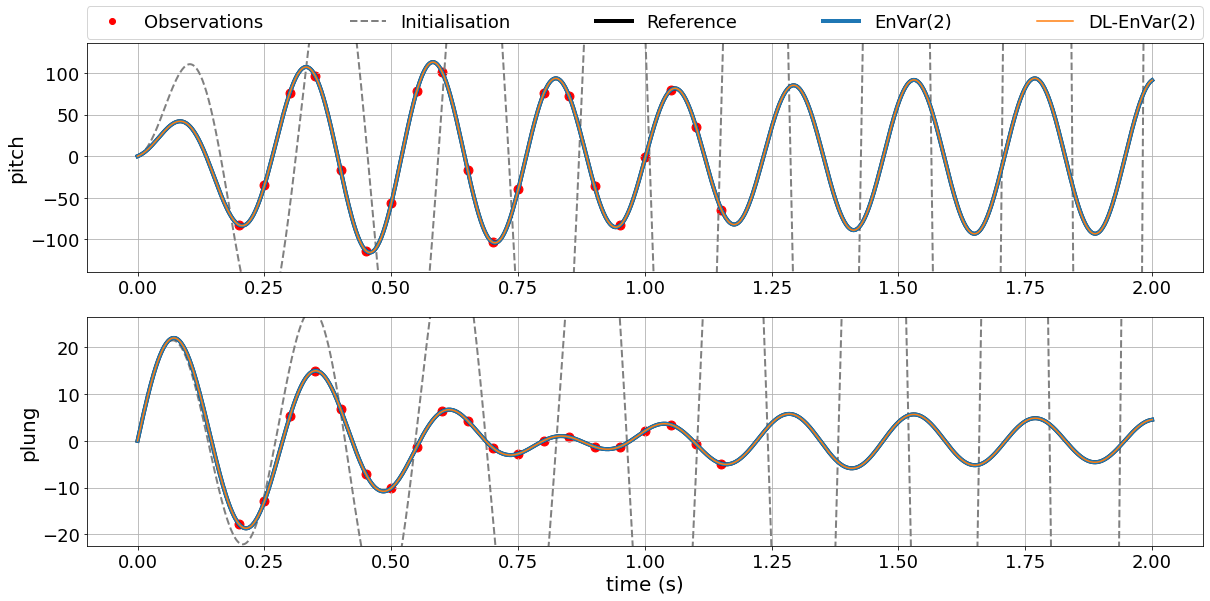

In [8]:
plt.figure(figsize=(20,100))
for i,name_obs in enumerate(PST_dic[label].CFG.Obs_Name) :
    plt.subplot(PST_dic[label].CFG.Number_Observation, 1 , i+1)
    plt.plot(PST_dic[label].time_obs, PST_dic[label].observations[:,i], 'o',color='r',label='Observations')
    plt.plot(PST_dic[label].time,PST_dic[label].observables_est[:,i],'--',color='grey',label='Initialisation' ,linewidth=2)
    plt.plot(PST_dic[label].time,PST_dic[label].observables_ref[:,i],'-',color='k',label='Reference',linewidth=4)
    k =0
    for key, PST in PST_dic.items():
        plt.plot(PST.time,PST.observables_opti[:,i],label=PST.label,linewidth=2*len(PST_dic) -k )
        k+=2.5
    plt.scatter(PST_dic[label].time_obs, PST_dic[label].observations[:,i], marker='o',color='r',s=80)
    v_min = np.min(PST_dic[label].observables_opti[:,i]) ; v_min=v_min - (v_min/abs(v_min))*v_min*0.2
    v_max = np.max(PST_dic[label].observables_opti[:,i]) ; v_max=v_max + (v_max/abs(v_max))*v_max*0.2 
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel(name_obs,fontsize=20)
    plt.ylim([v_min,v_max])
    plt.grid()
    if   i== 0:
        plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=5,fontsize=18)
plt.xlabel('time (s)',fontsize=20)
plt.show()

In [9]:
PST=PST_dic[label2]

In [10]:
df_samples = copy.copy(PST.get_ensembles_df())
df_samples["Status"] =""
df_samples

,mass,I_alpha,DA_Iter,Sample,Solver,Status
0,67.978416,1.786060,1,0,PAPA,
1,72.205822,1.140939,1,1,PAPA,
2,81.353758,1.585471,1,2,PAPA,
3,71.487889,2.281620,1,3,PAPA,
4,69.229683,1.202634,1,4,PAPA,
...,...,...,...,...,...,...
595,87.949018,3.879413,20,25,FNN,
596,86.092694,3.815869,20,26,FNN,
597,84.950536,3.646891,20,27,FNN,
598,89.914844,3.842125,20,28,FNN,


In [11]:
# N_ML = np.zeros(len(PST.J_cost)-1)
# N_HF = np.zeros(len(PST.J_cost)-1)
# for i in range(len(PST.J_cost)-1) :
#     N_ML[i] = df_samples.loc[ (df_samples["DA_Iter"] ==i) &  (df_samples["Solver"] == PST.CFG.DL_Model)].count()["Solver"]
#     N_HF[i] = df_samples.loc[ (df_samples["DA_Iter"] ==i) &  (df_samples["Solver"] == PST.CFG.Solver_Name)].count()["Solver"]   

# R_HF = (N_HF[0] - N_ML) / N_HF[0]

# N_tot = np.ones(len(PST.J_cost)-1)* N_HF[0]
# N_iter = np.arange(len(PST.J_cost)-1)+1
# plt.figure(figsize=(20,8))
# plt.bar(N_iter, N_tot,color="g", label ="ML")
# plt.bar(N_iter, N_HF,color="b",label ="HF")
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                             mode="expand", borderaxespad=0, ncol=4,fontsize=18)  
# plt.xlabel('N_iter',fontsize=15)
# plt.ylabel('Sample',fontsize=15)
# plt.show()

In [12]:
# with sns.axes_style("darkgrid"):

#     # Draw a nested barplot by species and sex
#     g = sns.catplot(
#         data=df_samples,x="Solver",hue="Solver",col = "DA_Iter", col_wrap=10,kind="count", height=2.5, aspect=.8
#     )


### Sample analysis during the optimisation process. 

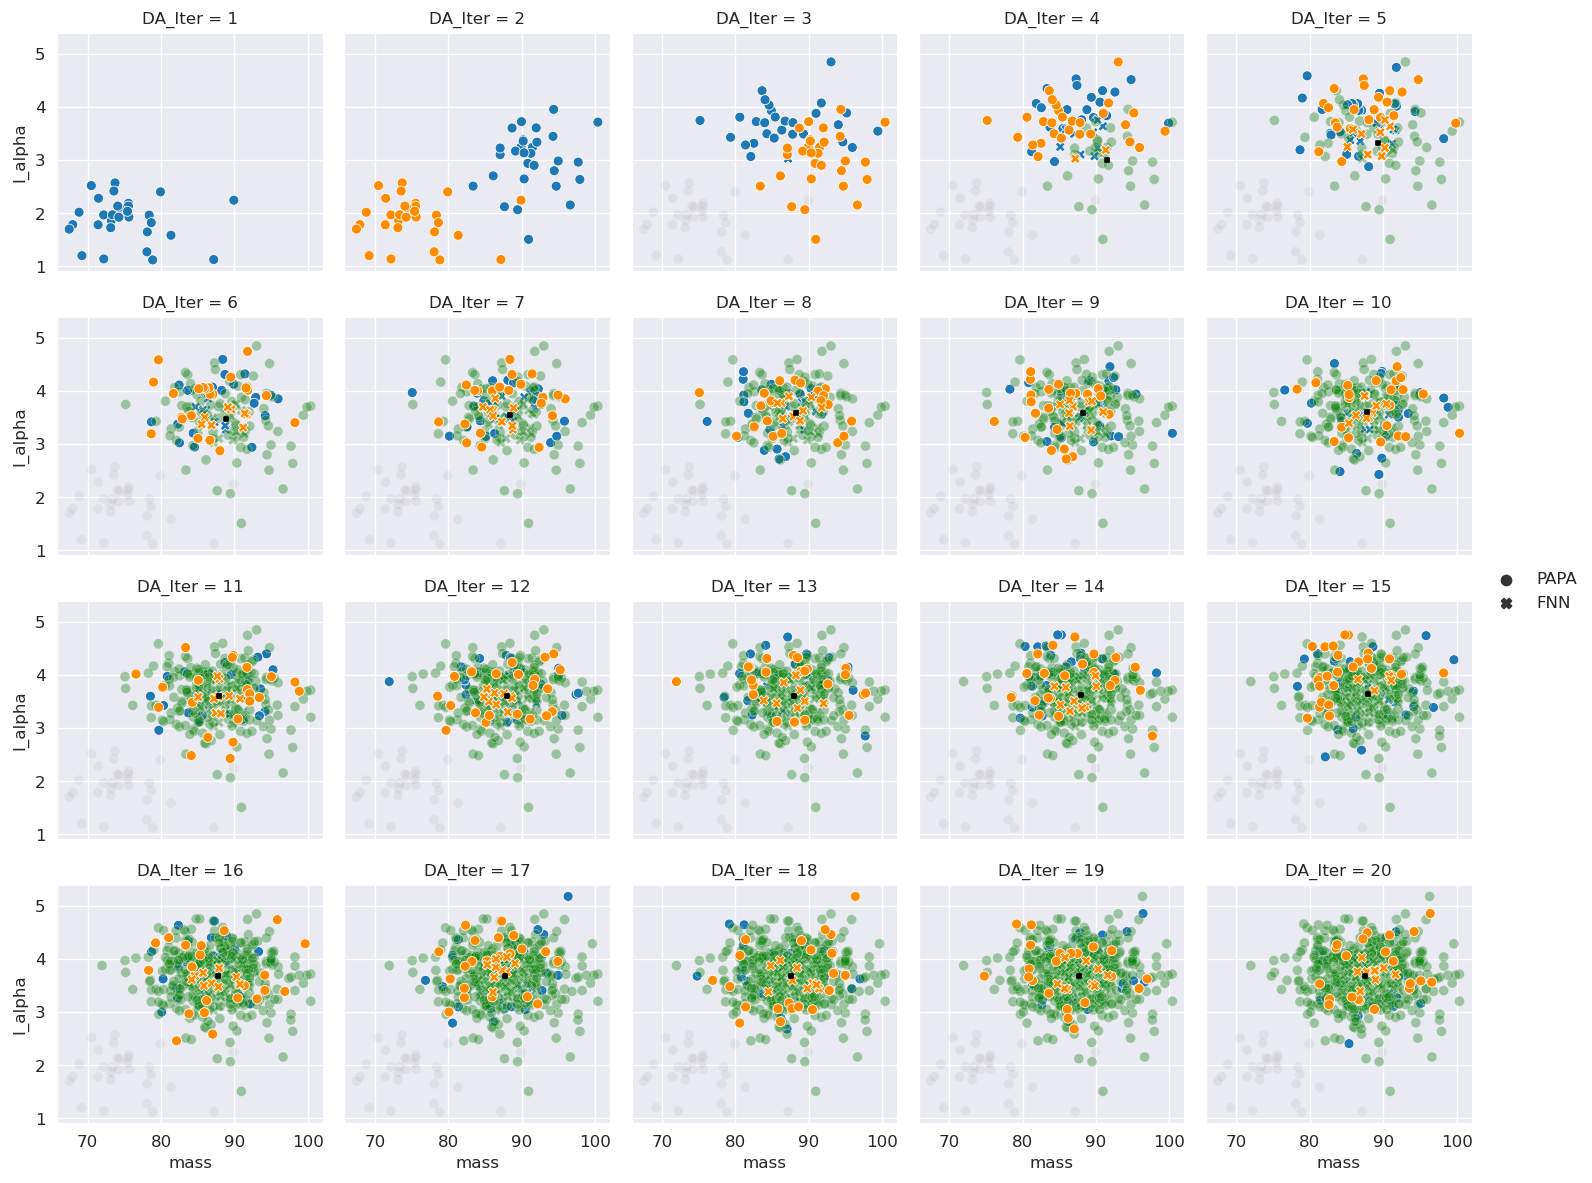

In [13]:
# df_samples[df_samples["DA_Iter"]==0]["Solver"]= /
# df_samples.loc[df_samples["DA_Iter"] == 1, "Status"] = "old"
# df_samples.loc[df_samples["DA_Iter"] == 0, "Status"] = "new"
# df_samples.loc[df_samples["DA_Iter"] == 59, "Status"] = "old"
with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples, col="DA_Iter", height=2.5, col_wrap=5)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    i_start_train = PST.i_start_ML -1
    for ax in g.axes.flatten() :
        
        ## ---- all old samples :
        if k>0 :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k)].copy()
        else :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_old, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")
        

        ## ----- new samples (Current)
        df_samples_new = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        
        ## update i start train 
        if PST.CFG.DL_Model not in df_samples_new["Solver"].values :
            i_start_train = k
        ## ---- Current train sample  
        if k>= PST.i_start_ML :
            df_sample_train = df_samples.loc[ (df_samples["DA_Iter"] >=i_start_train) & (df_samples["DA_Iter"] <k)].copy()   
            sns.scatterplot(data=df_sample_train, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.3,color="g")
        
        sns.scatterplot(data=df_samples_new, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")
        
        ## ----plot the prediction zone 
        if k>= PST.i_start_ML :
            # compute center 
            Samples_train = df_sample_train[PST.CFG.Param_Name].values
            if len(Samples_train)>0:
                center = np.zeros(PST.CFG.Param_Dim)
                for prm in Samples_train :
                    center+=prm
                center = (1/len(Samples_train))*center
                # rayon
                r =  PST.CFG.Rayon_Cluster

                theta = np.linspace(0, 2*np.pi, 100)
                x1 = r*np.cos(theta) + center[0]
                x2 = r*np.sin(theta) + center[1]
                
                ax.scatter([center[0]],[center[1]],marker = "s",color="k",s=5)
        
        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends


In [26]:
if np.nan>2 :
    print(1)

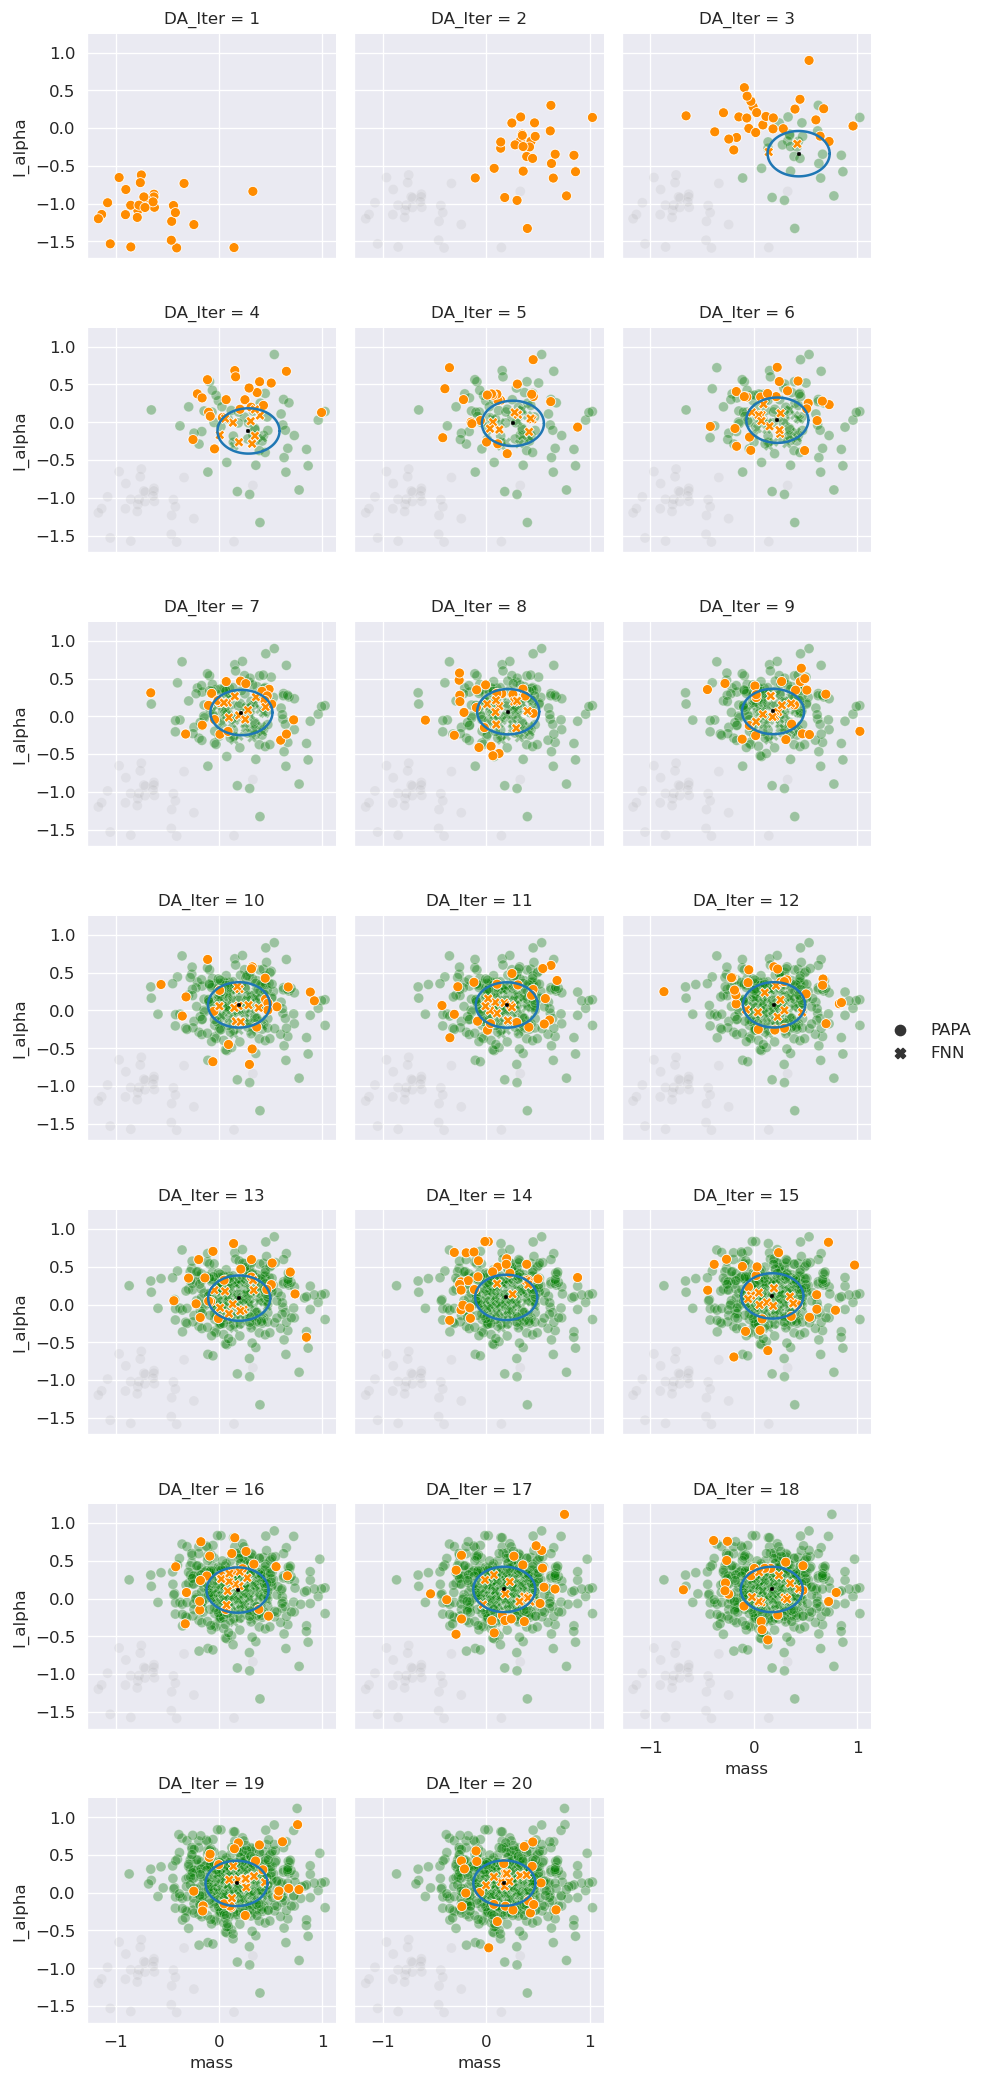

In [22]:
df_samples_bar  = copy.copy(df_samples)
for i,parm_nm in enumerate(PST.CFG.Param_Name): 
    df_samples_bar[parm_nm] =( 2*df_samples[parm_nm] - PST.CFG.Param_Bounds[i][0] -PST.CFG.Param_Bounds[i][1])\
                    / (PST.CFG.Param_Bounds[i][1]-PST.CFG.Param_Bounds[i][0])


with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples_bar, col="DA_Iter", height=2.5, col_wrap=3)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 1
    i_start_train = PST.i_start_ML -1
    for ax in g.axes.flatten() :
        
        ## ---- all old samples :
        if k>1 :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] <k)].copy()
        else :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_old_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")
        

        ## ----- new samples (Current)
        df_samples_new_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        
        ## update i start train 
        if PST.CFG.DL_Model not in df_samples_new_bar["Solver"].values :
            i_start_train = k
        ## ---- Current train sample  
        if k>= PST.i_start_ML :
            df_sample_train_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] >=i_start_train) & (df_samples_bar["DA_Iter"] <k)].copy()   
            sns.scatterplot(data=df_sample_train_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.3,color="g")
        
        sns.scatterplot(data=df_samples_new_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")
        
        ## ----plot the prediction zone 
        if k>= PST.i_start_ML :
            # compute center 
            Samples_train_bar = df_sample_train_bar[PST.CFG.Param_Name].values
            if len(Samples_train_bar)>0:
                center = np.zeros(PST.CFG.Param_Dim)
                for prm in Samples_train_bar :
                    center+=prm
                center = (1/len(Samples_train_bar))*center
                # rayon
                r =  PST.CFG.Rayon_Cluster

                theta = np.linspace(0, 2*np.pi, 100)
                x1 = r*np.cos(theta) + center[0]
                x2 = r*np.sin(theta) + center[1]
                ax.plot(x1,x2)
                ax.scatter([center[0]],[center[1]],marker = "s",color="k",s=1)
        
        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends

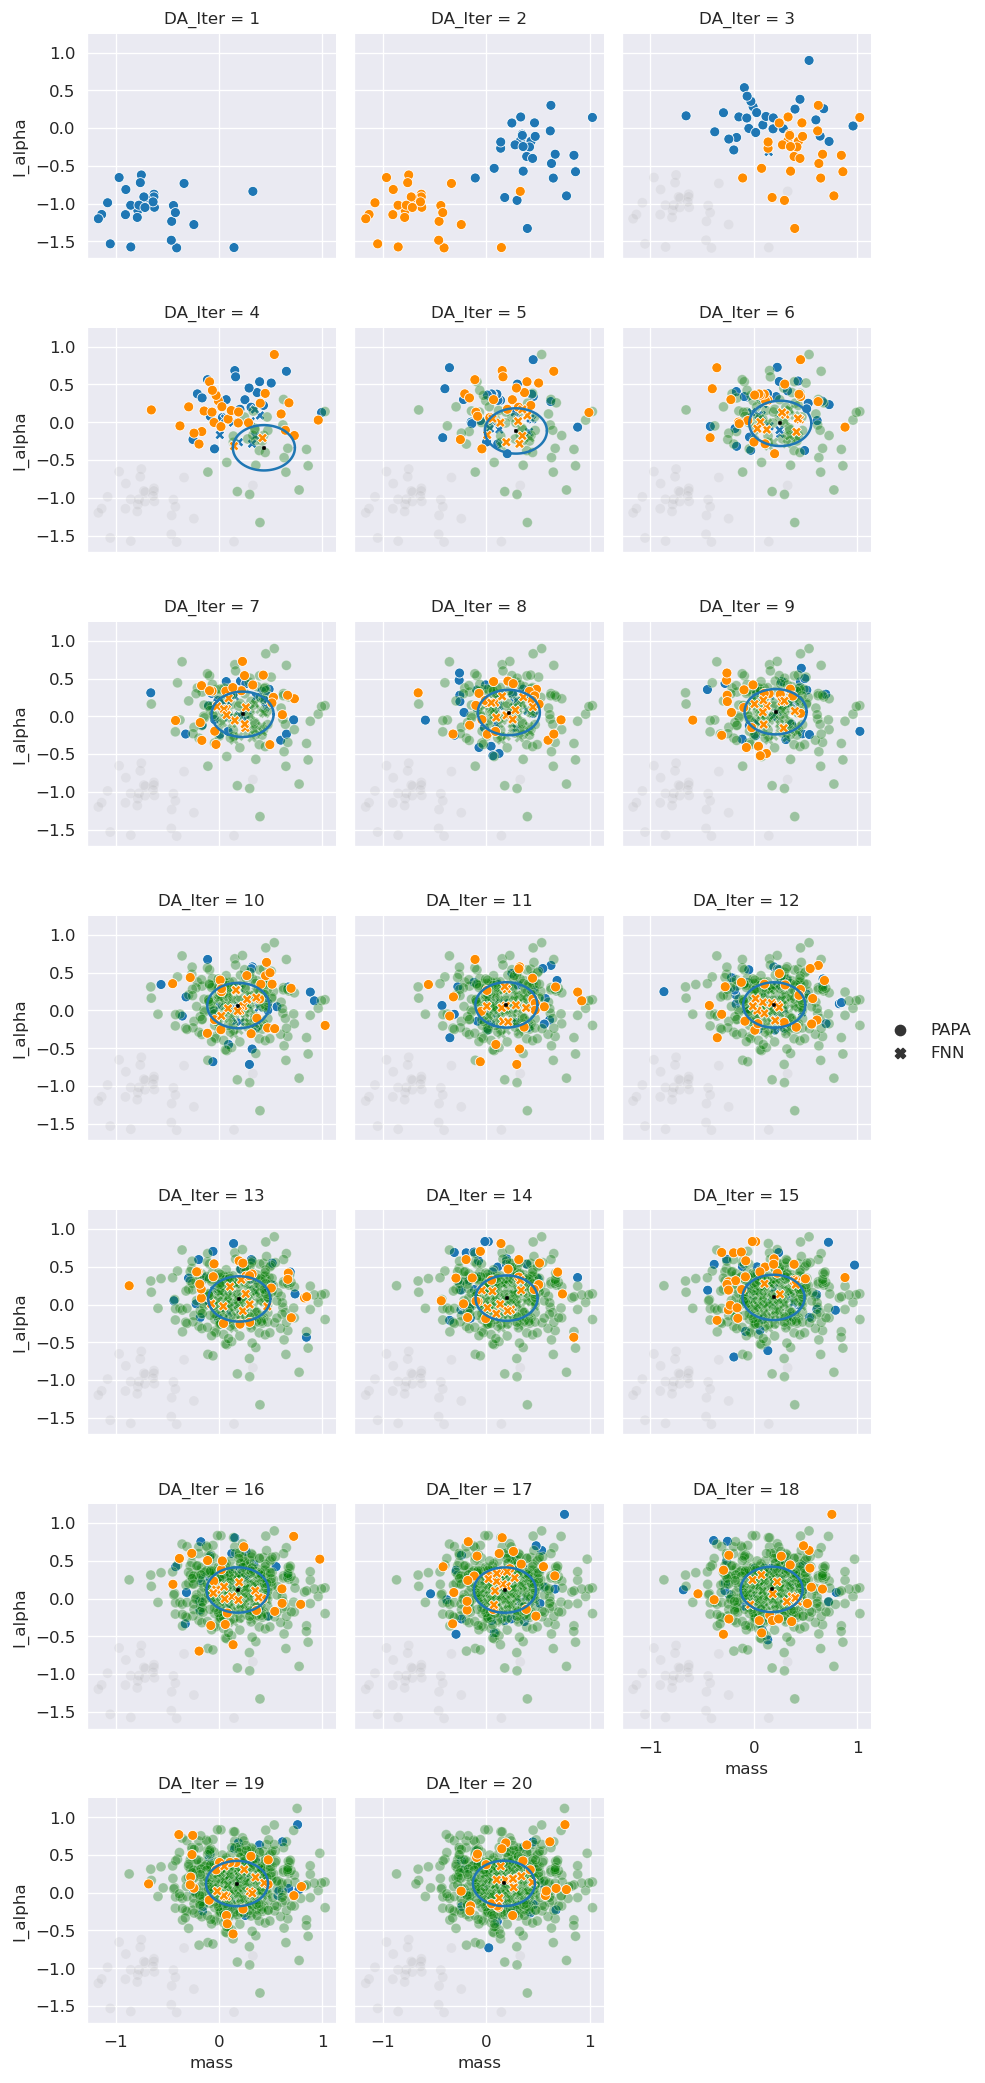

In [14]:
df_samples_bar  = copy.copy(df_samples)
for i,parm_nm in enumerate(PST.CFG.Param_Name): 
    df_samples_bar[parm_nm] =( 2*df_samples[parm_nm] - PST.CFG.Param_Bounds[i][0] -PST.CFG.Param_Bounds[i][1])\
                    / (PST.CFG.Param_Bounds[i][1]-PST.CFG.Param_Bounds[i][0])


with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples_bar, col="DA_Iter", height=2.5, col_wrap=3)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    i_start_train = PST.i_start_ML -1
    for ax in g.axes.flatten() :
        
        ## ---- all old samples :
        if k>0 :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] <k)].copy()
        else :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_old_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")
        

        ## ----- new samples (Current)
        df_samples_new_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        
        ## update i start train 
        if PST.CFG.DL_Model not in df_samples_new_bar["Solver"].values :
            i_start_train = k
        ## ---- Current train sample  
        if k>= PST.i_start_ML :
            df_sample_train_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] >=i_start_train) & (df_samples_bar["DA_Iter"] <k)].copy()   
            sns.scatterplot(data=df_sample_train_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.3,color="g")
        
        sns.scatterplot(data=df_samples_new_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")
        
        ## ----plot the prediction zone 
        if k>= PST.i_start_ML :
            # compute center 
            Samples_train_bar = df_sample_train_bar[PST.CFG.Param_Name].values
            if len(Samples_train_bar)>0:
                center = np.zeros(PST.CFG.Param_Dim)
                for prm in Samples_train_bar :
                    center+=prm
                center = (1/len(Samples_train_bar))*center
                # rayon
                r =  PST.CFG.Rayon_Cluster

                theta = np.linspace(0, 2*np.pi, 100)
                x1 = r*np.cos(theta) + center[0]
                x2 = r*np.sin(theta) + center[1]
                ax.plot(x1,x2)
                ax.scatter([center[0]],[center[1]],marker = "s",color="k",s=1)
        
        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends

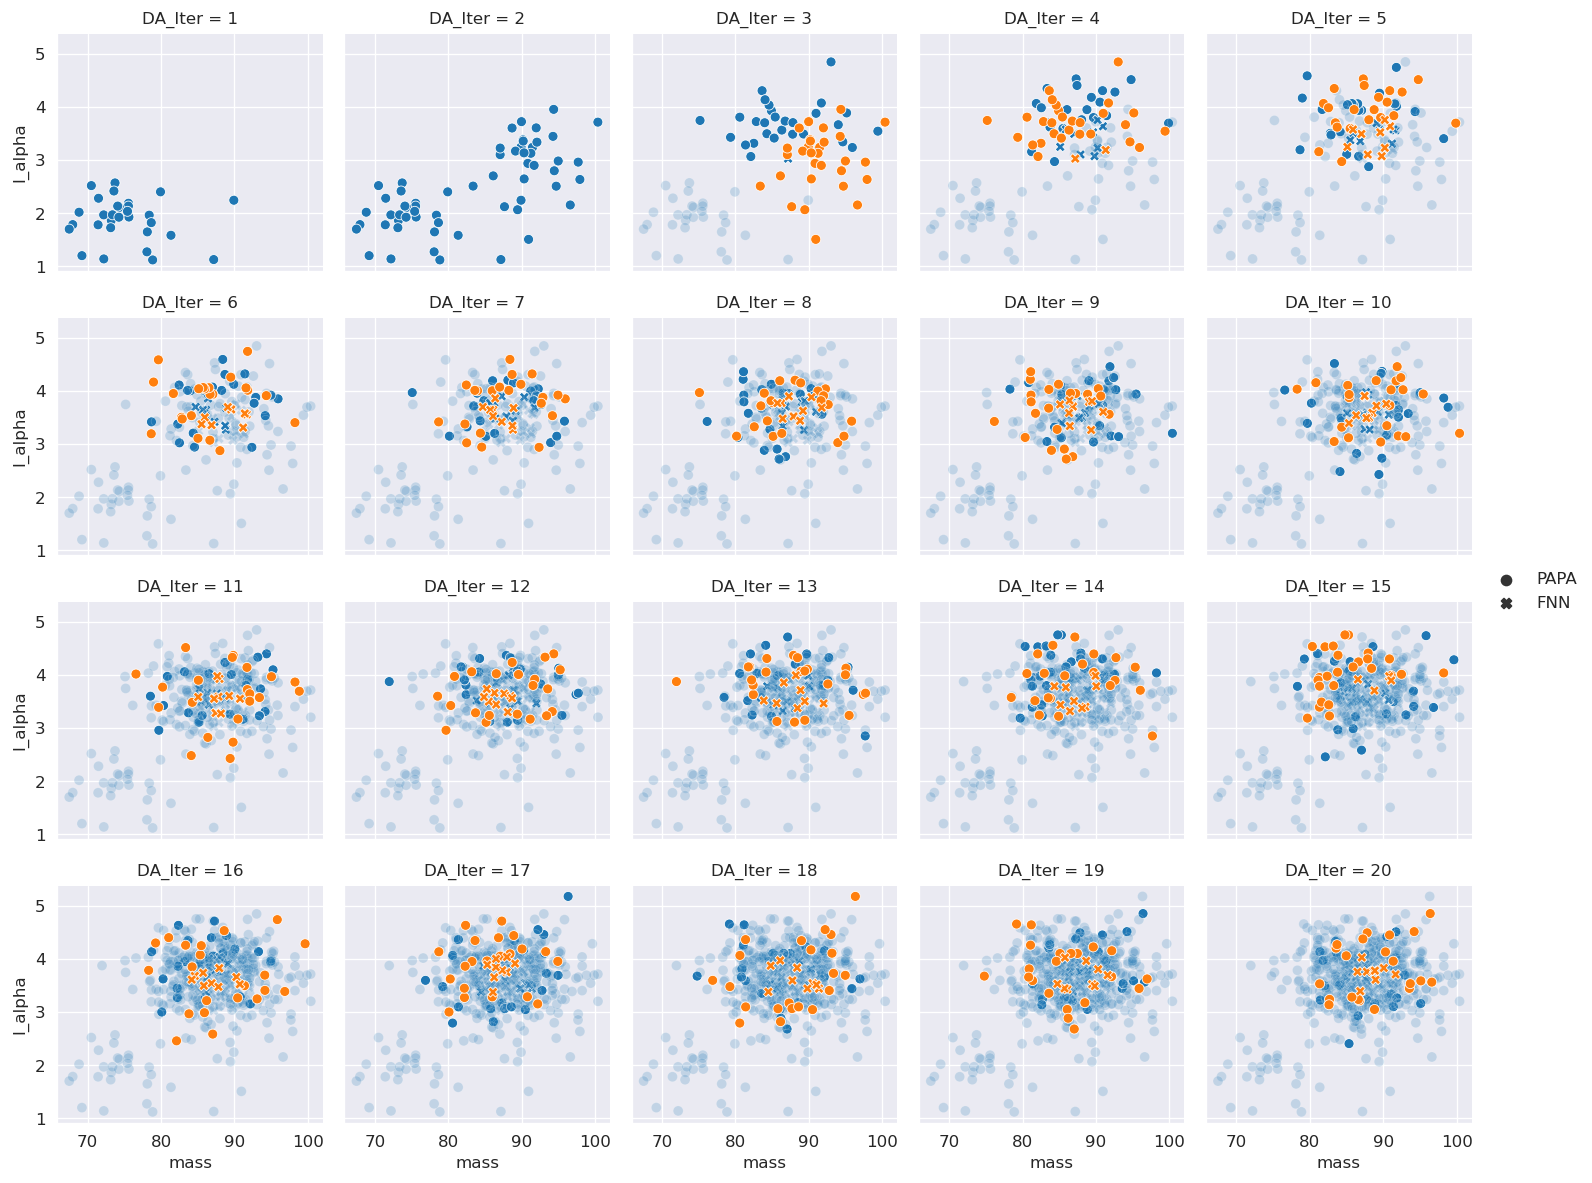

In [15]:
with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples, col="DA_Iter", height=2.5, col_wrap=5)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    for ax in g.axes.flatten() :
        if k>0 :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k)].copy()
        else :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
            
        sns.scatterplot(data=df_samples_old, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.2)
        df_samples_new = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_new, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.)

        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends


In [16]:
# plt.figure(figsize=(30,150))
# PST.plot_obs_ref_est_opt()